In [7]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Colab Notebooks/SDTRA/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install paquo
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, detectron2
import torchvision

!pip install toml
import toml
!mkdir qupath
!pip install paquo
!paquo get_qupath --install-path ./qupath 0.3.2
!python -m paquo config --list --default > .paquo.toml 
paquo_config = toml.load(".paquo.toml")
#paquo_config
paquo_config["qupath_dir"] = "/content/qupath/QuPath-0.3.2"
with open(".paquo.toml","w") as f:
  toml.dump(paquo_config,f)
from paquo.projects import QuPathProject
!apt update && apt install -y openslide-tools
!pip install openslide-python
import openslide

DEVICE = torch.device('cuda')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.4/211.4 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 37.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-4bng33oz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-4bng33oz
  Resolved https://github.com/facebookresearch/detectron2.git to commit 95a87b8dd359014d1ff81fe14f539dd279bcbe4b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 

In [ ]:
# -*- coding: utf-8 -*-
"""classificazione.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1gQZ8w953AvXIbCBugm3g6K6UKcm25zV5
"""

"""# ***PARTE 2 - SEGMENTAZIONE***"""
import argparse
import json
import os
import sys
#os.environ['PATH'] = r'C:\Program Files\openslide-win64-20220811\bin' + ";" + os.environ['PATH']
import torch, detectron2
import torchvision

import toml
from paquo.projects import QuPathProject
import openslide
#data_path = 'E:/DATASET DETECTRON/'
data_path = '/content/drive/MyDrive/Colab Notebooks/SDTRA/segmentation/'

DEVICE = torch.device('cuda')

import openslide
from PIL import Image
import os
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

def read_qupath_annotations(image):
    """Read annotations from QuPath image, return list"""
    annotations = image.hierarchy.annotations  # annotations are accessible via the hierarchy
    #print(f"Image {image.image_name} has {len(annotations)} annotations.")
    ann = [annotation.roi for annotation in annotations] if annotations else list()  # Return empty list if annotations are missing
    return ann, annotations

def get_new_coords(x, min=0, max=1000):
  flag = False
  if not round(x) in range(min, max):
      if x > max:
         x = float(max)
         flag = True
      elif x < min:
         x = float(min)
         flag = True
  return x, flag

def seg_list(boundary):
    x_min = 0
    y_min = 0
    x_max = 1000
    y_max = 1000

    count = 0
    seg_list = list()
    seg = list()

    if str(type(boundary)) == "<class 'shapely.geometry.multilinestring.MultiLineString'>":
        boundary = boundary.geoms[0]

    for x in list(boundary.coords):
        new_x, flag_x = get_new_coords(x[0], x_min, x_max)
        new_y, flag_y = get_new_coords(x[1], y_min, y_max)
        seg.append(new_x)
        seg.append(new_y)
        #seg_list.append(seg)
        #seg = list()
        if flag_x:
          count += 1
        if flag_y:
          count += 1
    
    seg_list.append(seg)
    score = 100 - (count/len(boundary.coords)) * 100
    return list(seg_list), score

def get_bbox(bbox):
  x_min = bbox[0]
  x_max = bbox[1]

  y_min = bbox[2]
  y_max = bbox[3]

  x_min_new, _ = get_new_coords(x_min)
  x_max_new, _ = get_new_coords(x_max)
  y_min_new, _ = get_new_coords(y_min)
  y_max_new, _ = get_new_coords(y_max)
  bbox_new = [x_min_new, x_max_new, y_min_new, y_max_new]

  return bbox_new

def create_annotations_list(ann, threshold = 30):
    annotations = []
    for i in range(len(ann)):
        #bbox = [ann[i].bounds[0], ann[i].bounds[1], ann[i].bounds[2], ann[i].bounds[3]]
        bbox = get_bbox(ann[i].bounds)
        # le prime due sono le coords di top left del rettangolo
        # le altre sono bottom right
        segmentation, score = seg_list(ann[i].boundary)

        if score > threshold:

            ann_dict = {'bbox': bbox,
                    'bbox_mode': 0, #BoxMode.XYXY_ABS
                    'category_id': 0,
                    'segmentation': segmentation} 

            annotations.append(ann_dict)
    return annotations

def get_dicts(img_dir):
    
    PROJECT_NAME1 = "PanGNBariSegmentationR2_out"
    PROJECT_NAME2 = "PanGNBariSegmentationR2_out2"
    PROJECT_NAME3 = "PanGNBariSegmentationR2_out3"
    PROJECT_NAME4 = "PanGNBariSegmentationR2_out3_test"
    
    #data_path = 'E:/DATASET DETECTRON/'
    data_path = '/content/drive/MyDrive/Colab Notebooks/SDTRA/segmentation/'
    data_path_glomeruli = data_path + 'PanGNBariCropped_'+ img_dir +'/'

    PROJECT_PATH1 = f"{data_path}/{PROJECT_NAME1}/project.qpproj"
    PROJECT_PATH2 = f"{data_path}/{PROJECT_NAME2}/project.qpproj"
    PROJECT_PATH3 = f"{data_path}/{PROJECT_NAME3}/project.qpproj"
    PROJECT_PATH4 = f"{data_path}/{PROJECT_NAME4}/project.qpproj"

    if img_dir == "train":
        project_paths = [PROJECT_PATH1, PROJECT_PATH2, PROJECT_PATH3]
        #project_paths = [PROJECT_PATH1]
    else:
        project_paths = [PROJECT_PATH4]
    dataset = []
  
    for project in project_paths:
        with QuPathProject(project, mode='r') as qp:
            print(f"Opened project ‘{qp.name}’ ")
            print(f"Project has {len(qp.images)} image(s).")
          
            if img_dir == 'train':
              num_images = 5
              threshold = 45
            else:
              num_images = len(qp.images)
              #num_images = 10
              threshold = 35
            
            for i in range(num_images): 
                image = qp.images[i]
                fname = data_path_glomeruli + image.image_name
                #image.uri = fname
                image_id, ext = os.path.splitext(fname)
                image_id = image_id[-4:].replace('_',' ')
                print(image_id)
                #print(f'Image ID {image_id}')
                print(f'num imag {i}')
                ann, annots = read_qupath_annotations(image)
                annotations = create_annotations_list(ann, threshold)
                image_dict = {'file_name': fname, 'height': image.height, 'width': image.width, 'image_id': image_id, 'annotations':annotations}
                              
                dataset.append(image_dict)

    return dataset

flag = True
if flag == True:
    #DatasetCatalog.remove('glomeruli_train')
    #DatasetCatalog.remove('glomeruli_test')

    for subset in ['train','test']:
        DatasetCatalog.register("glomeruli_"+ subset, lambda subset=subset: get_dicts(subset))
        if subset == "train":
            dataset_dicts_train = DatasetCatalog.get("glomeruli_"+subset)
        else:
            dataset_dicts_test = DatasetCatalog.get("glomeruli_"+subset)

    glomeruli_metadata_train = MetadataCatalog.get("glomeruli_train")
    glomeruli_metadata_test = MetadataCatalog.get("glomeruli_test")

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode

if __name__ == '__main__':
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("glomeruli_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 1
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 300000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    #os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    #trainer = DefaultTrainer(cfg)
    #trainer.resume_or_load(resume=False)
    #trainer.train()
    data_path = '/content/drive/MyDrive/Colab Notebooks/SDTRA/segmentation/'
    cfg.MODEL.WEIGHTS = os.path.join(data_path +"results_detectron/model_final.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    from detectron2.evaluation import COCOEvaluator, inference_on_dataset
    from detectron2.data import build_detection_test_loader
    MetadataCatalog.get("glomeruli_test").thing_classes = ["glomerulus"]
    evaluator = COCOEvaluator("glomeruli_test", output_dir="./output")
    val_loader = build_detection_test_loader(cfg, "glomeruli_test")
    #print(inference_on_dataset(predictor.model, val_loader, evaluator))
    # another equivalent way to evaluate the model is to use `trainer.test
    detectron_res = inference_on_dataset(predictor.model, val_loader, evaluator)
    #torch.save(outputs, 'output_detectron.pt')
    #torch.save(detectron_res, data_path+'results_detectron.pt')

In [14]:
data_path = '/content/drive/MyDrive/Colab Notebooks/SDTRA/'
cfg.MODEL.WEIGHTS = os.path.join(data_path +"data/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
MetadataCatalog.get("glomeruli_test").thing_classes = ["glomerulus"]
evaluator = COCOEvaluator("glomeruli_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "glomeruli_test")
#print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test
detectron_res = inference_on_dataset(predictor.model, val_loader, evaluator)
#torch.save(outputs, 'output_detectron.pt')
#torch.save(detectron_res, data_path+'results_detectron.pt')

Output hidden; open in https://colab.research.google.com to view.

In [18]:
from detectron2.structures import Boxes, pairwise_iou
import numpy as np
import cv2, random
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer, ColorMode

d = dataset_dicts_test[0]
        
#cm = np.zeros([num_classes+1, num_classes+1])
im = cv2.imread(d["file_name"])
outputs = predictor(im)
out = outputs['instances']

In [19]:
out

Instances(num_instances=1, image_height=1000, image_width=1000, fields=[pred_boxes: Boxes(tensor([[455.1556, 431.4213, 546.8929, 566.3670]], device='cuda:0')), scores: tensor([0.9998], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])

In [ ]:
from detectron2.structures import Boxes, pairwise_iou
import numpy as np
import cv2, random
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer, ColorMode

num_classes = 1
iou_threshold = 0.6
#cm_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cm_threshold = [0.5]
#cms = {'0.1': [],
#       '0.2': [],
#       '0.3': [],
#       '0.4': [],
#       '0.5': [],
#       '0.6': [],
#       '0.7': [],
#       '0.8': [],
#       '0.9': []
#           }
cms = list() 


for cm_thres in cm_threshold:
    cm_tot = np.zeros([num_classes+1, num_classes+1])

    for d in dataset_dicts_test:
        
        cm = np.zeros([num_classes+1, num_classes+1])
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        out = outputs['instances']

        gt = {'id': [],
              'bbox': []}
        preds = {'classes': [],
                'scores': [],
                'bbox': []}

        for ann in d['annotations']:

            gt['id'].append(ann['category_id'])
            gt['bbox'].append(ann['bbox'])

        for p_bbox, p_score, p_class in zip(out.get('pred_boxes').tensor.cpu().numpy(),
                                            out.get('scores').cpu().numpy(),
                                            out.get('pred_classes').cpu().numpy()):
             
            if p_score > cm_thres:
                preds['scores'].append(p_score)
                preds['classes'].append(p_class)
                preds['bbox'].append([p_bbox])

        #CONFUSION MATRIX
        gt_detected = np.zeros(len(gt['id']))
        p_matched = np.zeros(len(preds['bbox']))
        for gt_idx, (gt_class, gt_bbox) in enumerate(zip(gt['id'], gt['bbox'])):
            for p_idx, (p_class, p_bbox) in enumerate(zip(preds['classes'], preds['bbox'])):
                
                iou = pairwise_iou(Boxes(p_bbox), Boxes([gt_bbox]))
                
                if iou >= iou_threshold:
                  
                  cm[gt_class, p_class] += 1 #sempre (0,0) TP
                  gt_detected[gt_idx] = 1
                  p_matched[p_idx] = 1

                
        if len(gt_detected) > len(p_matched):
            for idx, val in enumerate(gt_detected): #FN (1,0)
                if (val==0):
                  cm[-1, gt['id'][idx]] += 1

        elif len(gt_detected) < len(p_matched):
            for idx, val in enumerate(p_matched): #FP (0,1)
                if (val==0):
                  cm[preds['classes'][idx], -1] += 1
        else:
            for idx, val in enumerate(p_matched): #FP (0,1)
                  if (val==0):
                    cm[gt['id'][idx], -1] += 1

            for idx, val in enumerate(p_matched):   #FN (1,0)
                if (val==0): 
                  cm[-1, preds['classes'][idx]] += 1
        
        cm_tot += cm
    #cms[str(cm_thres)].append(cm_tot)
    cms.append(cm_tot)

/usr/local/lib/python3.8/dist-packages/detectron2/structures/boxes.py:148: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=torch.device("cpu"))


In [ ]:
import matplotlib.pyplot as plt

def plot_pr_curve(recall, precision):
  plt.plot(recall, precision, linewidth = 2)
  plt.show()

In [ ]:
import torch, json
det_res = torch.load(data_path + 'results_detectron.pt')


In [ ]:
det_res

OrderedDict([('bbox',
              {'AP': 75.15934312353136,
               'AP50': 86.50905036411818,
               'AP75': 83.97913279350658,
               'APs': 58.118811881188115,
               'APm': 45.5662777271168,
               'APl': 82.21332008103793}),
             ('segm',
              {'AP': 75.55533828518978,
               'AP50': 86.29377386852501,
               'AP75': 83.81660414542094,
               'APs': 0.0,
               'APm': 41.12564135539573,
               'APl': 83.9505502712771})])

In [ ]:
#cm_tot
TP = 1138 #cm_tot[0,0]
FP = 202 #cm_tot[1,0]
FN = 75 #cm_tot[0,1]
TN = 0 #cm_tot[1,1]

precision = TP / (TP+FP)
recall = TP /(TP+FN)
F1 = ((precision * recall) /(precision + recall)) * 2
ACC = (TP + TN)/(TP + TN + FP + FN)
#specificity = TN / (TN + FP)

print('Precision:   \t\t', precision)
print('Recall:      \t\t', recall)
#print('Specificity: \t\t', specificity)
print('Dice coefficient: \t', F1)
print('Accuracy:    \t\t', ACC)

Precision:   		 0.8492537313432836
Recall:      		 0.9381698268755152
Specificity: 		 0.0
Dice coefficient: 	 0.891500195848022
Accuracy:    		 0.8042402826855124


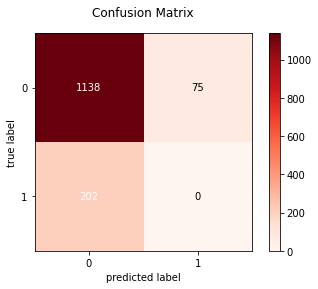

NameError: ignored

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
classes = ['glomerulus', 'non-glomerulus']
cm = np.array([[1138, 75],
       [202, 0]])
figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = True,
                                   show_normed = False,
                                   colorbar = True,
                                   cmap = 'Reds')
plt.title('Confusion Matrix')
plt.show()


#cm_tot

In [ ]:
import cv2, random
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer, ColorMode

#for d in random.sample(dataset_dicts_test, 1):
for d in dataset_dicts_test:
    im = cv2.imread(d["file_name"])
    print(d['image_id'])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                    metadata=glomeruli_metadata_test,
                    scale=0.5,
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


Output hidden; open in https://colab.research.google.com to view.